In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline
from sklearn import metrics
from numpy.random import seed
seed(1)
from tensorflow import random
tf.set_random_seed(2)
from datetime import datetime
from alpha_vantage.timeseries import TimeSeries
import os 
from scipy import stats as stat
import warnings
from afinn import Afinn
afinn = Afinn()
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
cpy = pd.read_csv('Company.csv')
cpy_tweet = pd.read_csv('Company_Tweet.csv')
tweet = pd.read_csv('Tweet.csv')
tweets = pd.merge(tweet,cpy_tweet,on='tweet_id',how='inner')
tweets['date'] = pd.to_datetime(tweets['post_date'].apply(lambda date: datetime.fromtimestamp(date).date()))

In [3]:
tweets = tweets.drop(['tweet_id'],axis=1)

In [167]:
tweets.ticker_symbol.value_counts()

AAPL     1425013
TSLA     1096868
AMZN      718715
GOOG      392569
MSFT      375711
GOOGL     327569
Name: ticker_symbol, dtype: int64

In [4]:
aapl = tweets[tweets['ticker_symbol'] == 'AAPL']
tsla = tweets[tweets['ticker_symbol'] == 'TSLA']
amzn = tweets[tweets['ticker_symbol'] == 'AMZN']
msft = tweets[tweets['ticker_symbol'] == 'MSFT']
goog = tweets[tweets['ticker_symbol'] == 'GOOG']
googl = tweets[tweets['ticker_symbol'] == 'GOOGL']

In [5]:
def stock_getter(ticker, output):
    ts = TimeSeries(key='DIR3OHC94MGGVLVO', output_format ='pandas')
    data, metadata = ts.get_daily_adjusted(ticker ,outputsize= output)
    data.reset_index(inplace=True)
    #adjusting the stocks for the 2015-219
    data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
    data1 = data.loc[data['date'] >='2015-01-02']
    a_stock = data1.loc[data['date'] <= '2019-12-30']
    a_stock= a_stock.drop(columns=['5. adjusted close',"7. dividend amount","8. split coefficient" ])
    a_stock = a_stock.rename(columns={"date":"date", "1. open":"Open","2. high":"High", "3. low" : "Low", "4. close":"Close", 
                          "6. volume":"Volume"})
    a_stock.sort_values(by='date', inplace = True)
    a_stock.reset_index(inplace=True)
    return a_stock

In [6]:
aapl_stock = stock_getter("AAPL", "full")
tsla_stock = stock_getter("TSLA", "full")
msft_stock = stock_getter("MSFT", "full")
amzn_stock = stock_getter("AMZN", "full")
googl_stock = stock_getter("GOOGL", "full")

In [7]:
def tweet_vol_affect(tweets,stocks,title):
    
    stocks['date'] = pd.to_datetime(stocks['date'])
    stocks = stocks[['Volume', 'date']].dropna().set_index('date')
    tweets = tweets.groupby('date').size().rolling(30).mean().dropna().reindex(stocks.index)
    stocks['Volume'] = stocks['Volume'].rolling(30).mean().dropna()
    corr, pval = stat.spearmanr(tweets, stocks['Volume'], nan_policy='omit')
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    ax1.plot(tweets.index, tweets, label='Tweet Volume')
    ax2.plot(stocks.index, stocks['Volume'], color='orange', label='Trade Volume')

    ax1.set_ylabel('Tweet Volume')
    ax2.set_ylabel('Trade Volume')
    ax2.set_title(title + "\nSpearman correlation: corr={:.5f} pval={:.5f}".format(float(corr), float(pval)))

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    plt.show()

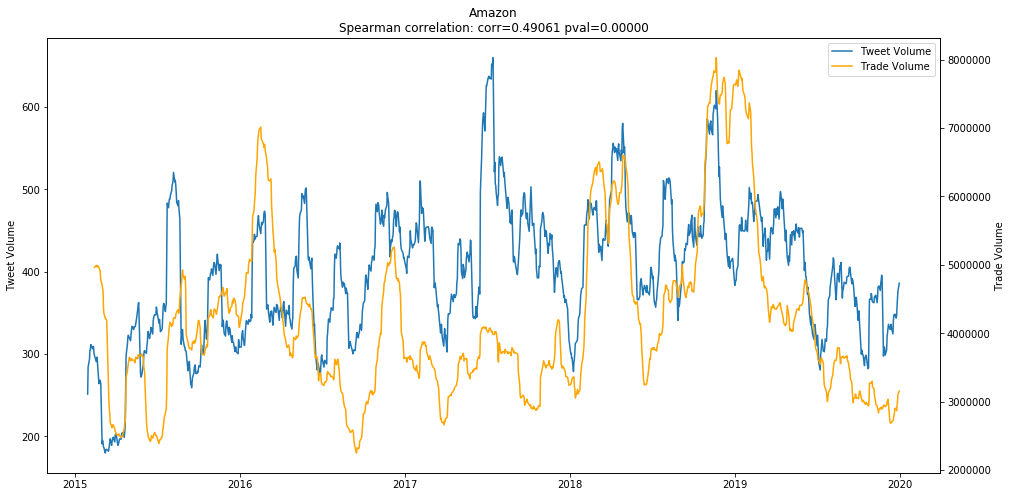

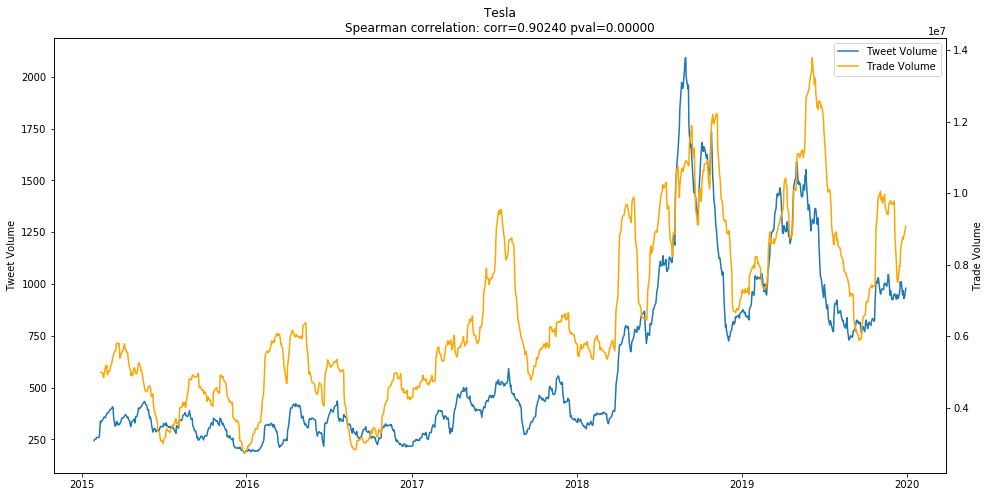

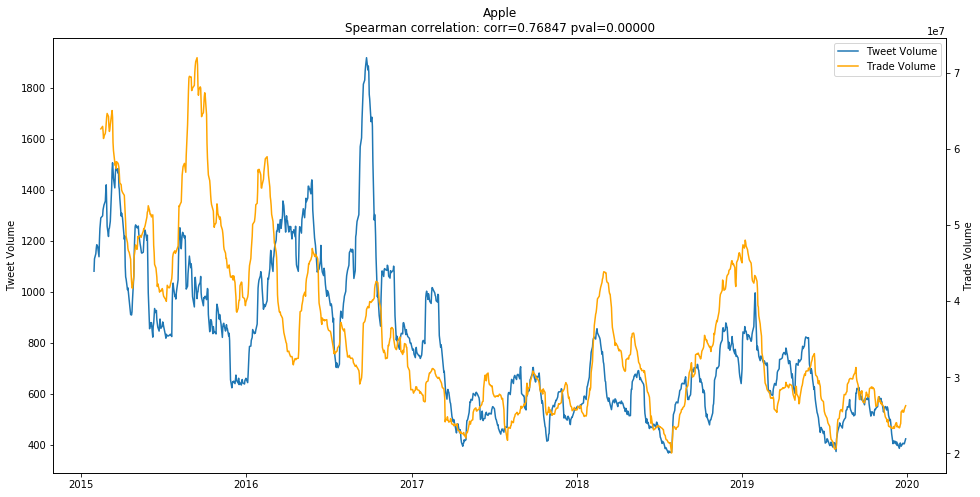

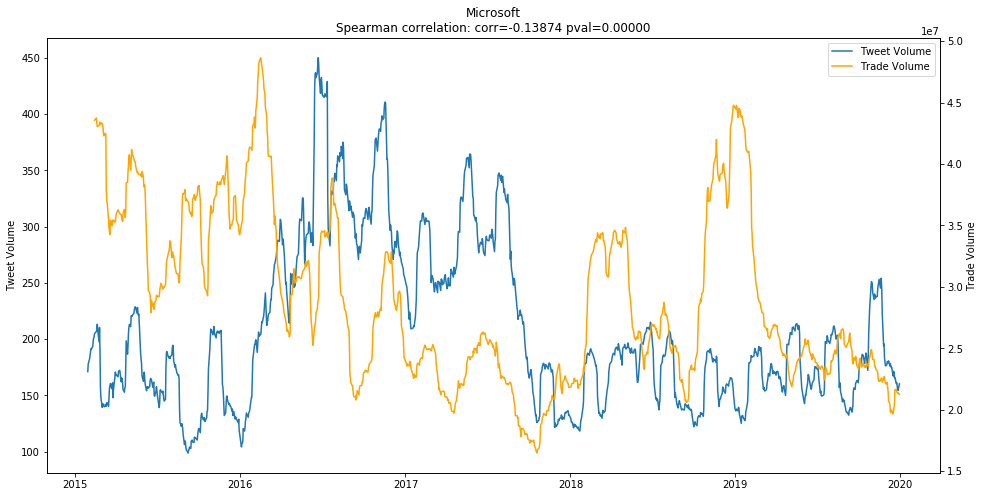

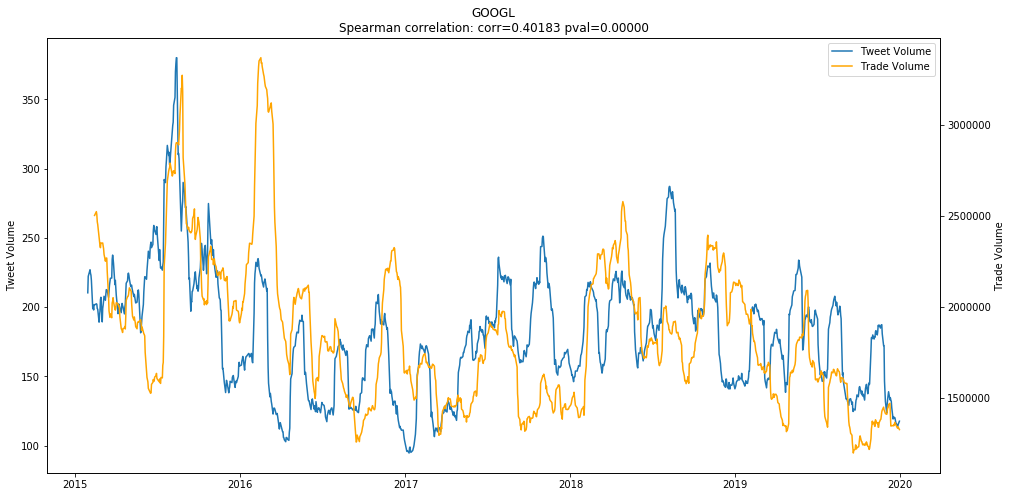

In [8]:
tweet_vol_affect(amzn, amzn_stock, "Amazon")
tweet_vol_affect(tsla, tsla_stock, "Tesla")
tweet_vol_affect(aapl, aapl_stock, "Apple")
tweet_vol_affect(msft, msft_stock, "Microsoft")
tweet_vol_affect(googl, googl_stock, "GOOGL")

In [9]:
warnings.filterwarnings("ignore", category=FutureWarning)
tsla.loc[:, 'score'] = tsla['body'].astype(str).apply(lambda tweet: afinn.score(tweet))
aapl.loc[:,'score'] = aapl['body'].astype(str).apply(lambda tweet: afinn.score(tweet))
amzn.loc[:,'score'] =  amzn['body'].astype(str).apply(lambda tweet: afinn.score(tweet))
msft.loc[:,'score'] =  msft['body'].astype(str).apply(lambda tweet: afinn.score(tweet))
googl.loc[:,'score'] =  googl['body'].astype(str).apply(lambda tweet: afinn.score(tweet))

C:\Users\codey\Anaconda\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


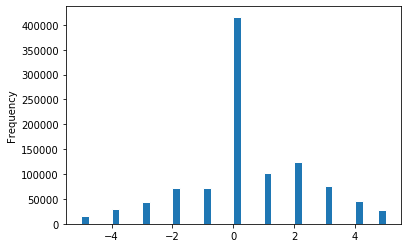

In [10]:
tsla.score.plot(kind='hist',range=(-5,5),bins=40,edgecolor='white');

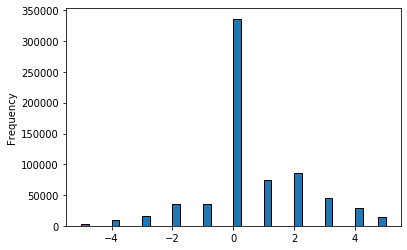

In [11]:
amzn.score.plot(kind='hist',range=(-5,5),bins=40,edgecolor='black');

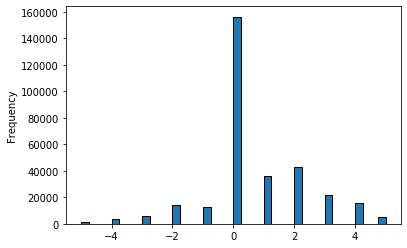

In [12]:
googl.score.plot(kind='hist',range=(-5,5),bins=40,edgecolor='black');

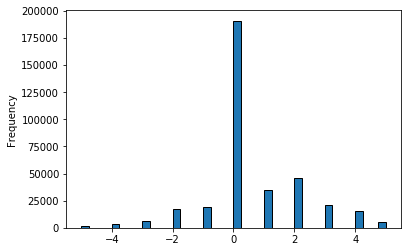

In [13]:
msft.score.plot(kind='hist',range=(-5,5),bins=40,edgecolor='black');

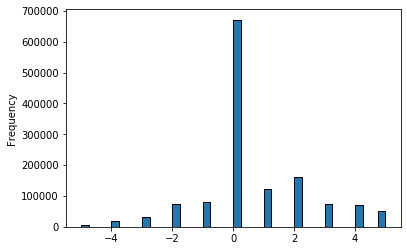

In [14]:
aapl.score.plot(kind='hist',range=(-5,5),bins=40,edgecolor='black');

In [15]:
def sentiment_overtime(tweets, stock, title):
    visual = tweets.groupby('date')['score'].mean().shift(-1).rolling(31).mean().dropna()
    visual = visual.reset_index()
    corr_test = tweets.groupby('date')['score'].mean().shift(-1).dropna()
    corr_test = corr_test.reset_index()
    corr, pval = stat.spearmanr(corr_test['score'].reindex(stock.index), stock['Close'], nan_policy='omit')
    
    fig, ax1 = plt.subplots(figsize=(8, 8))
    ax2 = ax1.twinx()
    merged = pd.merge(corr_test, visual, on='date', how='outer')
    merged = pd.merge(merged, stock[['Close', 'date']], on='date', how='left')
    merged = merged.dropna(subset=['score_x', 'score_y', 'Close'])
    
    # subset data for only years 2015-2019
    merged = merged[(merged['date'].dt.year >= 2015) & (merged['date'].dt.year <= 2019)]
    #merged["volume"] = stock['Volume'].dropna()
    ax1.plot(merged['date'], merged['score_y'], label='Tweets Sentiment')
    ax2.plot(merged['date'], merged['Close'], color='orange', label='Share Price')

    ax2.set_title("Effects of "+title+" tweets to share price using Afinn" +"\n Spearman correlation : corr={0:.5f} pval={1:.5f}".format(corr,pval))
    
    # set the x-axis of ax1 to the years in merged
    xticks = pd.date_range(start='2015-01-01', end='2019-12-31', freq='YS')
    xlabels = [d.strftime('%Y') for d in xticks]
    ax1.set_xticks(xticks, minor=False)
    ax1.set_xticklabels(xlabels, rotation=45)
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    plt.tight_layout()
    plt.show()
    return merged

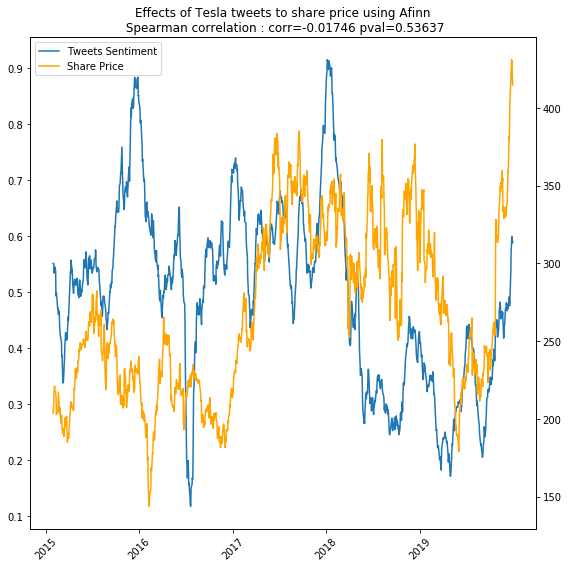

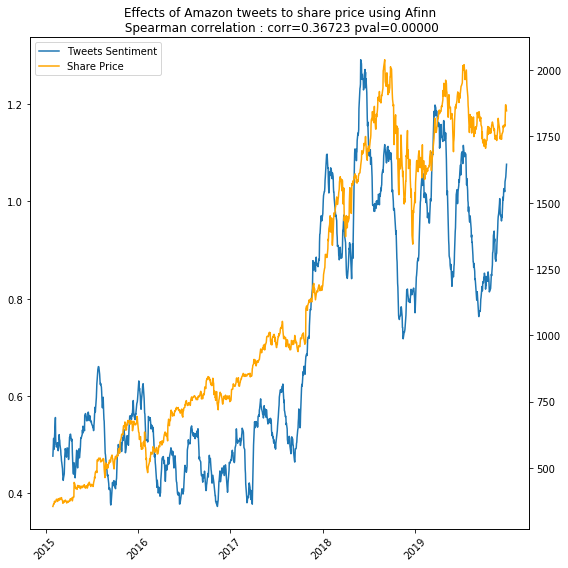

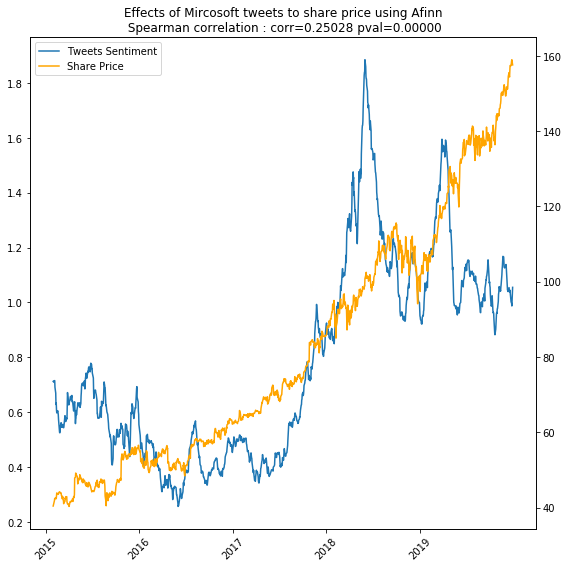

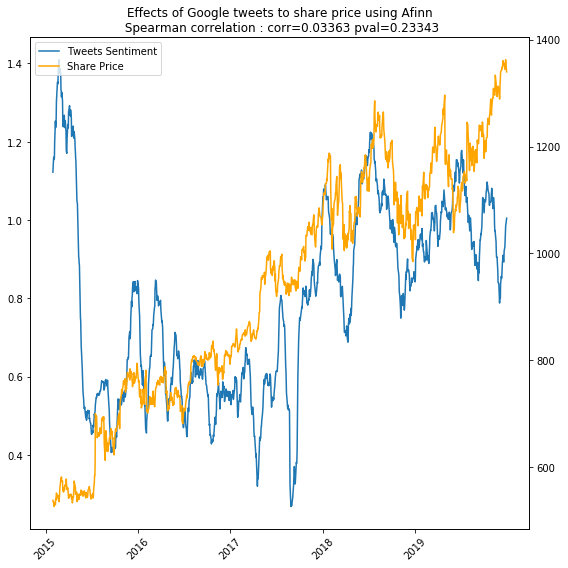

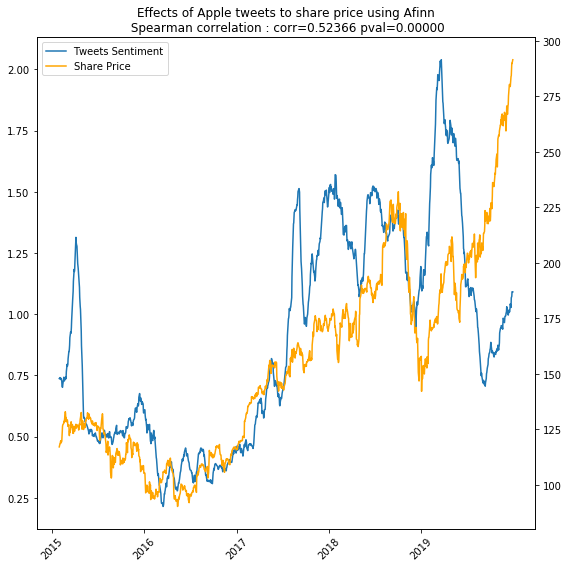

In [16]:
tsla_sen = sentiment_overtime(tsla,tsla_stock,"Tesla");
amzn_sen = sentiment_overtime(amzn,amzn_stock,"Amazon");
msft_sen =sentiment_overtime(msft,msft_stock,"Mircosoft");
googl_sen = sentiment_overtime(googl,googl_stock,"Google");
aapl_sen =sentiment_overtime(aapl,aapl_stock,"Apple");

In [17]:
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_sent", "X_rolling" and y
    X_open = []
    X_sent = []
    X_rolling = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts, tw_vol, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts = df.iloc[i:(i + window), feature_col_number2]
        ts_rolling = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_open.append(close)
        X_sent.append(ts)
        X_rolling.append(ts_rolling)
        y.append(target)
        
    return np.hstack((X_open,X_sent,X_rolling)), np.array(y).reshape(-1, 1)

In [18]:
def data_train(sent_stock):
# Predict Closing Prices using a 3 day window of previous closing prices
    window_size = 3
# Column index 3 is the `Adj Close` column
# Column index 1 is the `sent_for each_tweet` column
# Column index 2 is the `rolling avg of sent` column
    feature_col_number1 = 3
    feature_col_number2 = 1
    feature_col_number3 = 2
    target_col_number = 3
    X, y = window_data(sent_stock, window_size, feature_col_number1,feature_col_number2, feature_col_number3, target_col_number)

    # Use 70% of the data for training and 30% for testing
    X_split = int(0.7 * len(X))
    y_split = int(0.7 * len(y))
    X_train = X[: X_split]
    X_test = X[X_split:]
    y_train = y[: y_split]
    y_test = y[y_split:]
    x_train_scaler = MinMaxScaler()
    x_test_scaler = MinMaxScaler()
    y_train_scaler = MinMaxScaler()
    y_test_scaler = MinMaxScaler()
    x_train_scaler.fit(X_train)
    y_train_scaler.fit(y_train)
    X_train = x_train_scaler.transform(X_train)
    y_train = y_train_scaler.transform(y_train)
    x_test_scaler.fit(X_test)
    y_test_scaler.fit(y_test)
    X_test = x_test_scaler.transform(X_test)
    y_test = y_test_scaler.transform(y_test)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    return X_test, X_train, y_test, y_train,y_test_scaler

In [19]:
aapl_test, aapl_train, appl_testy, appl_trainy, aapl_test_scaler = data_train(aapl_sen)
tsla_test, tsla_train, tsla_testy, tsla_trainy, tsla_test_scaler = data_train(tsla_sen)
msft_test, msft_train, msft_testy, msft_trainy, msft_test_scaler = data_train(msft_sen)
googl_test, googl_train, googl_testy, googl_trainy, googl_test_scaler = data_train(googl_sen)
amzn_test, amzn_train, amzn_testy, amzn_trainy, amzn_test_scaler = data_train(amzn_sen)

In [20]:
def modelbuilder(X_test,X_train,y_test, y_train):
    model = Sequential()
    number_units = 9
    dropout_fraction = 0.2
    model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_fraction))
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error")
    model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=5, verbose=0)
    model.evaluate(X_test, y_test)
    predicted = model.predict(X_test)
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
    print('R-squared :', metrics.r2_score(y_test, predicted))
    return predicted

In [ ]:
amzn_predicted = modelbuilder(amzn_test, amzn_train, amzn_testy, amzn_trainy)
aapl_predicted = modelbuilder(aapl_test, aapl_train, appl_testy, appl_trainy)
msft_predicted = modelbuilder(msft_test, msft_train, msft_testy, msft_trainy)
googl_predicted = modelbuilder(googl_test, googl_train, googl_testy, googl_trainy)
tsla_predicted = modelbuilder(tsla_test, tsla_train, tsla_testy, tsla_trainy)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
371/371 [==============================] - 0s 479us/sample - loss: 0.0058
Root Mean Squared Error: 0.0764011044054865
R-squared : 0.8197216751735277
371/371 [==============================] - 0s 672us/sample - loss: 0.1126
Root Mean Squared Error: 0.33561182901539716
R-squared : -1.6425026706646504


In [179]:
import holoviews as hv
import hvplot.pandas
def predictmodel(X_test, y_test, predicted, name, merged, y_test_scaler):
    predicted_prices = y_test_scaler.inverse_transform(predicted)
    real_prices = y_test_scaler.inverse_transform(y_test)
    real_prices = y_test_scaler.inverse_transform(y_test)
    real_prices = pd.Series(real_prices.ravel()).dropna().values
    merged = merged.iloc[-len(real_prices):].reset_index(drop=True)
    merged = merged.sort_index().reset_index()
    stocks =  pd.DataFrame({
        "Real": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
    }, index=merged[-len(real_prices):].index)
    xticks = pd.date_range(start='2015', end='2019', freq='YS')
    xlabels = [d.strftime('%Y') for d in xticks]
    plot = stocks.hvplot(title="Real vs Predicted values of AFinn LSTM " + name, xticks=xticks, xlabel='Year', ylabel='Stock Price')
    plot.opts(yformatter="%.0f",  width=450, height=300)
    #print(stocks)
    return plot

In [180]:
import holoviews as hv
from bokeh.layouts import gridplot
from bokeh.plotting import show
df = predictmodel(googl_test, googl_testy, googl_predicted, "GOOGL", googl_sen, googl_test_scaler)
df1 = predictmodel(tsla_test, tsla_testy, tsla_predicted, "TSLA", tsla_sen, tsla_test_scaler)
df2 = predictmodel(amzn_test, amzn_testy, amzn_predicted, "AMZN", amzn_sen, amzn_test_scaler)
df3 = predictmodel(msft_test, msft_testy, msft_predicted, "MSFT", msft_sen, msft_test_scaler)
plot1 = hv.render(df)
plot2 = hv.render(df1)
plot3 = hv.render(df2)
plot4 = hv.render(df3)

grid = gridplot([[plot1, plot2], [plot3, plot4]], width=380, height=250)

# show the grid plot
show(grid)

In [169]:
predictmodel(aapl_test, appl_testy, aapl_predicted, "AAPL", aapl_sen, aapl_test_scaler)

:NdOverlay   [Variable]
   :Curve   [index]   (value)